###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from littlegrad.engine import Value
from littlegrad.nn import Neuron, Layer, MLP

In [3]:
np.random.seed(1337)
random.seed(1337)

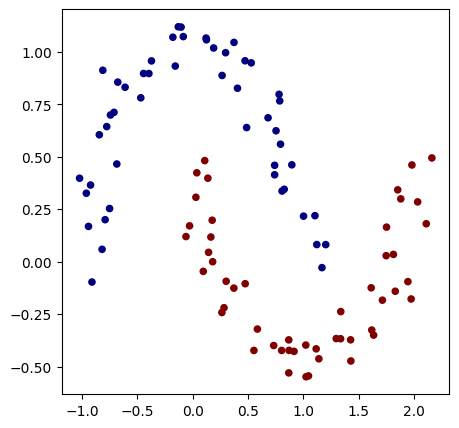

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

#y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
# initialize a model 
model = MLP(2, [25, 15, 2]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2), ReLU_Neuron(2)], Layer of [ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25), ReLU_Neuron(25)], Layer of [Linear_Neuron(15), Linear_Neuron(15)]]
number of parameters 497


In [6]:
# loss function
#from karpathy's micrograd_exercises.ipynb
def softmax(logits):
  counts = [logit.exp() for logit in logits]
  denominator = sum(counts)
  out = [c / denominator for c in counts]
  return out

#modified from karpathy's demo.ipynb
def loss(batch_size = None):

    if batch_size is None:  #dataloader
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    losses, accuracy = [], []
    for (xrow, yrow) in zip(Xb, yb):
        inputs = list(map(Value, xrow))  #Value(xrow[i])
        outputs = model(inputs)  #forward pass
        probs = softmax(outputs)  #softmax layer
        #losses.append(-probs[yrow].log())  #negative log likelyhood loss
        losses.append(-probs[int(yrow.item())].log())  # cuz makemoons() didn't have dtype=int like I have
        #losses.append(-outputs[int(yrow.item())].log())
        #accuracy.append(0)
        accuracy.append(yrow == np.argmax([prob.data for prob in probs])) #check if it would have guessed correctly

    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    #reg_loss = alpha * sum((p.data**2 for p in model.parameters()))
    total_loss = (sum(losses) / len(losses)) + reg_loss

    return total_loss, sum(accuracy) / len(accuracy) #TODO: fix accruacy and use total_loss (total_loss causes max recursion depth error for get_child?)


In [7]:
# optimization
for k in range(48):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    #print('total_loss:', total_loss.children)
    #print('parameters:', model.parameters())
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/48
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    #print('parameters:', model.parameters())
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 3.055720196814895, accuracy 50.0%
step 1 loss 0.836758705739008, accuracy 57.99999999999999%
step 2 loss 4.615872243153496, accuracy 50.0%
step 3 loss 0.9134989468543645, accuracy 50.0%
step 4 loss 0.4682082923037283, accuracy 79.0%
step 5 loss 0.34627875552019327, accuracy 81.0%
step 6 loss 0.3405149170171126, accuracy 83.0%
step 7 loss 0.3305977657484411, accuracy 83.0%
step 8 loss 0.3184598505631393, accuracy 86.0%
step 9 loss 0.3054077994318191, accuracy 85.0%
step 10 loss 0.29917576168014426, accuracy 86.0%
step 11 loss 0.2860815467632045, accuracy 87.0%
step 12 loss 0.28412228602312, accuracy 87.0%
step 13 loss 0.2839867252081512, accuracy 88.0%
step 14 loss 0.27780585118287315, accuracy 87.0%
step 15 loss 0.27419870482986625, accuracy 88.0%
step 16 loss 0.2720267524960987, accuracy 86.0%
step 17 loss 0.2750656914805679, accuracy 89.0%
step 18 loss 0.26631923331651547, accuracy 85.0%
step 19 loss 0.2677094093798066, accuracy 90.0%
step 20 loss 0.2583812406427786, accu

(-1.548639298268643, 1.951360701731357)

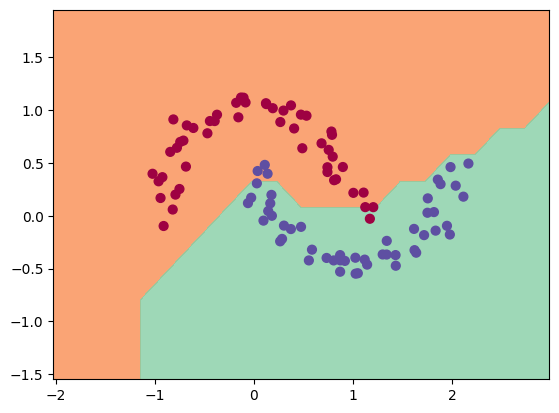

In [8]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
#inputs = [list(map(Value, xrow)) for xrow in Xmesh]
#outputs = list(map(model, inputs))
#probs = list(map(softmax, inputs))
#scores = np.array([np.argmax([p.data for p in prob]) for prob in probs])
scores = []
for xrow in Xmesh:
    inputs = list(map(Value, xrow))  #Value(xrow[i])
    outputs = model(inputs)  #forward pass
    probs = softmax(outputs)  #softmax layer
    scores.append(np.argmax([prob.data for prob in probs]))

#Z = np.array([s.data > 0 for s in scores])
Z = np.array([s > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


In [9]:
print(300/1e-100)

3e+102
